# Imports

In [860]:
from collections import Counter

In [861]:
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA

In [862]:
import numpy as np

In [863]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
plt.rcParams["image.cmap"] = "Dark2"

# Setup Data

In [864]:
n_obs = 2048
n_feats = 2

In [865]:
params_linear = dict(
    n_samples=n_obs, n_features=n_feats,
    centers=[[-2, -2], [2, 2]],
    cluster_std=1.5
)

In [866]:
params_blobs = dict(
    n_samples=n_obs, n_features=n_feats,
    centers=[
        [-2, -2], [2, 2],
        [-2, 2], [2, -2],
    ],
    cluster_std=1.2
)

In [867]:
params_moons = dict(
    n_samples=n_obs, noise=0.2,
)

## Linear
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [868]:
def get_linear():
    data, target = datasets.make_blobs(**params_linear)
    target = (target == 1) * 2 - 1
    return data, target

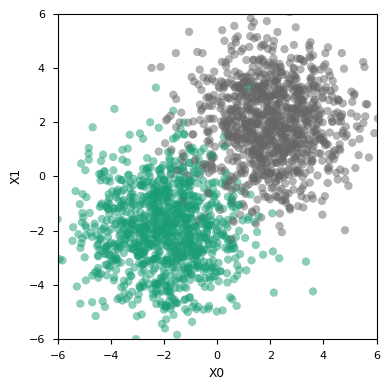

In [869]:
data, target = get_linear()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

## Blobs
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [870]:
def get_blobs():
    data, target = datasets.make_blobs(**params_blobs)
    target = np.isin(target, [0, 1]) * 2 - 1
    return data, target

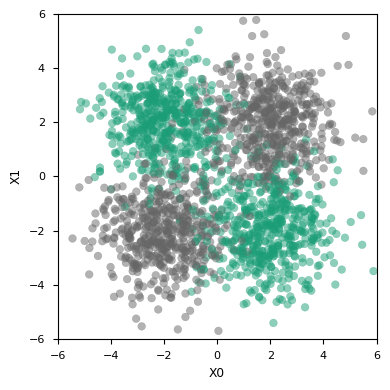

In [871]:
data, target = get_blobs()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

## Moons
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

In [872]:
def get_moons():
    data, target = datasets.make_moons(**params_moons)

    target = (target == 1) * 2 - 1
    data = data - [data[:, 0].mean(), data[:, 1].mean()]
    return data, target

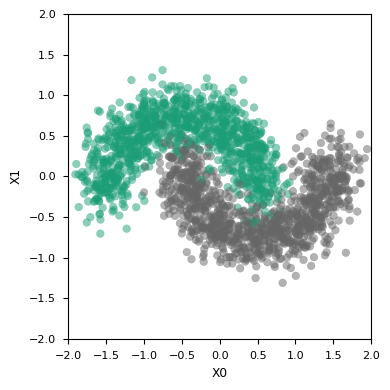

In [873]:
data, target = get_moons()

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=target, alpha=.5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("X0")
plt.ylabel("X1")
plt.tight_layout()
plt.show()
plt.close()

# Modeling

In [874]:
neurons = 100

## Step by step

### Training

In [875]:
X_train, X_test, y_train, y_test = train_test_split(*get_blobs(), test_size=.3)

* Generate random hidden layer weights

In [876]:
w_input = np.random.uniform(size=(X_train.shape[1] + 1, neurons))
w_input.shape

(3, 100)

* Calculate hidden layer input

In [877]:
hidden_input = (
    np.hstack([np.ones(shape=(X_train.shape[0], 1)), X_train])
    @ w_input
)
hidden_input.shape

(1433, 100)

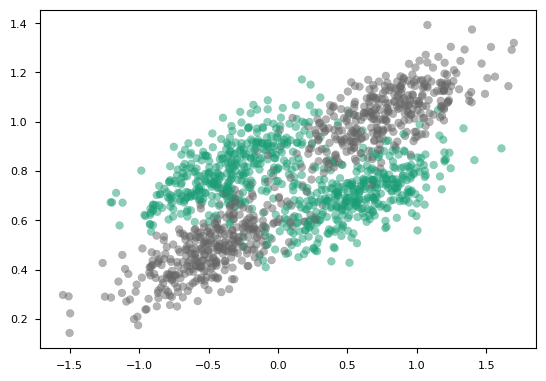

In [878]:
plt.scatter(hidden_input[:, 0], hidden_input[:, 1], c=y_train, alpha=.5)

* Calculate hidden layer output

In [879]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(X_train.shape[0], 1)),
    hidden_output
])
hidden_output.shape

(1433, 101)

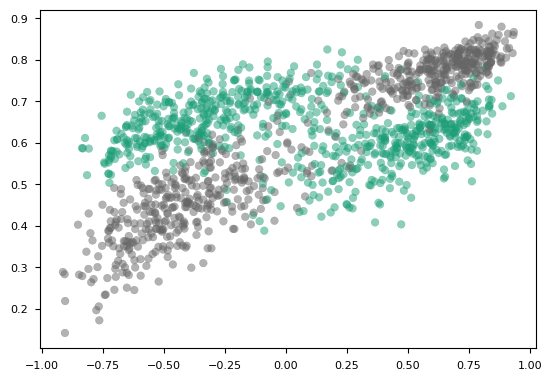

In [880]:
plt.scatter(hidden_output[:, 1], hidden_output[:, 2], c=y_train, alpha=.5)

* Calculate PCA weights to set up second hidden layer

In [881]:
means = hidden_output.mean(axis=0)
zero_mean = hidden_output - means
cov = np.cov(zero_mean.T)
eig_val, eig_vec = np.linalg.eig(np.round(cov, 5))

In [882]:
threshold = .01

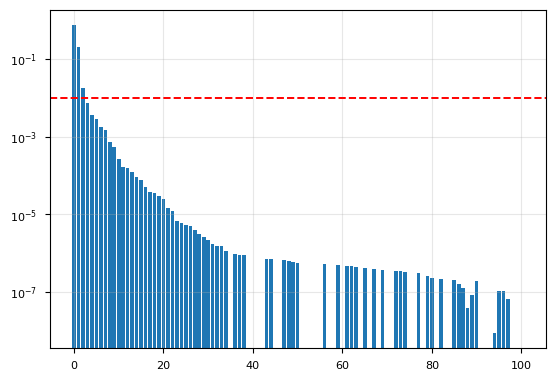

In [883]:
explained_var = eig_val / np.sum(eig_val)
plt.bar(range(explained_var.shape[0]), explained_var)
plt.yscale("log")
plt.grid(alpha=.3)
plt.axhline(threshold, color="red", ls="--")

In [884]:
eig_vec_sel = eig_vec @ np.tile((explained_var > threshold).astype("int"), (neurons + 1, 1))

In [885]:
# TODO: EIGEN VECTOR SELECTOR
pca_output = np.dot(zero_mean, eig_vec_sel)
pca_output.shape

(1433, 101)

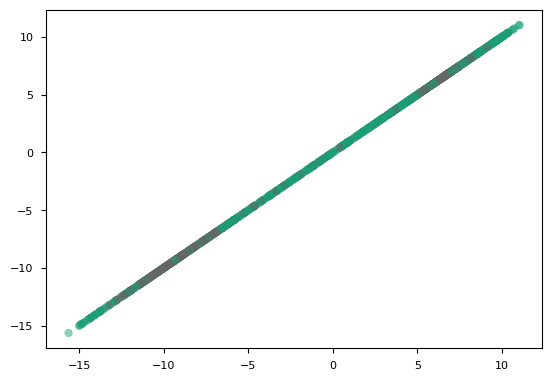

In [886]:
plt.scatter(pca_output[:, 0], pca_output[:, 1], c=y_train, alpha=.5)

* Calculate output layer weights

In [887]:
w_output = np.linalg.pinv(pca_output) @ y_train
w_output.shape

(101,)

* Calculate and evaluat training predictions

In [888]:
output_input = pca_output @ w_output
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1
preds.shape

(1433,)

In [889]:
print(classification_report(
    y_true=y_train, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.57      0.62      0.59       732
           1       0.56      0.50      0.53       701

    accuracy                           0.56      1433
   macro avg       0.56      0.56      0.56      1433
weighted avg       0.56      0.56      0.56      1433



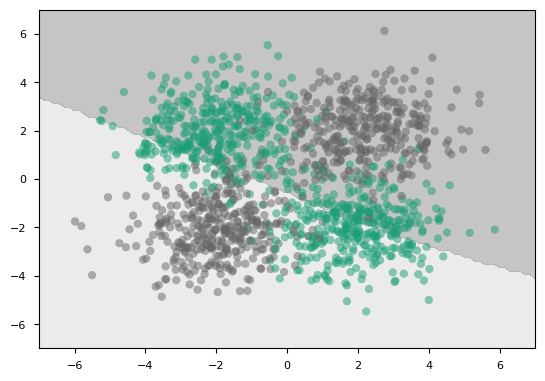

In [890]:
steps = 100
value = np.ceil(np.max([X_train.max(), np.abs(X_train.min())]))
grid = np.linspace(-1 * value, value, num = steps)
grid_data = np.array([[x0, x1] for x0 in grid for x1 in grid])

hidden_input = (
    np.hstack([np.ones(shape=(grid_data.shape[0], 1)), grid_data])
    @ w_input
)
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(grid_data.shape[0], 1)),
    hidden_output
])
pca_output = np.dot(hidden_output - means, eig_vec_sel)
output_input = pca_output @ w_output
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1

plt.contourf(
    grid, grid,
    (preds * -1 > 0).reshape(steps, steps),
    levels=1, alpha=.3, cmap="binary"
)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=.5)

### Testing

* Calculate hidden layer input

In [891]:
hidden_input = (
    np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
    @ w_input
)
hidden_input.shape

(615, 100)

* Calculate hidden layer output

In [892]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(X_test.shape[0], 1)),
    hidden_output
])
hidden_output.shape

(615, 101)

* Calculate PCA output

In [893]:
# TODO: EIGEN VECTOR SELECTOR
pca_output = np.dot(hidden_output - means, eig_vec_sel)

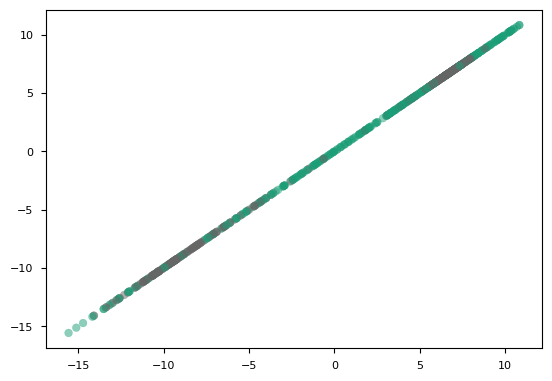

In [894]:
plt.scatter(pca_output[:, 0], pca_output[:, 1], c=y_test, alpha=.5)

* Calculate output layer input values

In [895]:
output_input = pca_output @ w_output
output_input.shape

(615,)

* Output layer activation function is linear

In [896]:
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1
preds.shape

(615,)

### Evaluate

In [897]:
print(classification_report(
    y_true=y_test, y_pred=preds,
    zero_division=0,
))

              precision    recall  f1-score   support

          -1       0.52      0.64      0.57       292
           1       0.59      0.47      0.52       323

    accuracy                           0.55       615
   macro avg       0.55      0.55      0.55       615
weighted avg       0.56      0.55      0.55       615



#### Grid

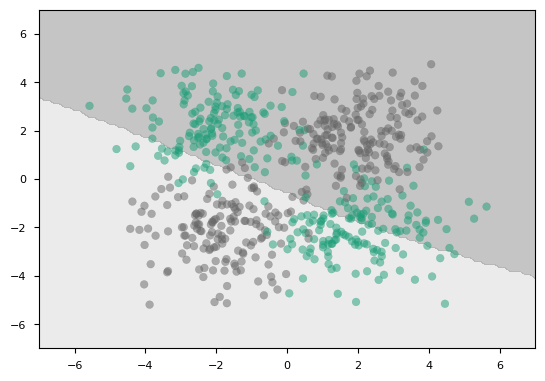

In [898]:
steps = 100
value = np.ceil(np.max([X_train.max(), np.abs(X_train.min())]))
grid = np.linspace(-1 * value, value, num = steps)
grid_data = np.array([[x0, x1] for x0 in grid for x1 in grid])

hidden_input = (
    np.hstack([np.ones(shape=(grid_data.shape[0], 1)), grid_data])
    @ w_input
)
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([
    np.ones(shape=(grid_data.shape[0], 1)),
    hidden_output
])
pca_output = np.dot(hidden_output - means, eig_vec_sel)
output_input = pca_output @ w_output
preds = (output_input.reshape(-1, 1) > 0).reshape(-1) * 2 - 1

plt.contourf(
    grid, grid,
    (preds * -1 > 0).reshape(steps, steps),
    levels=1, alpha=.3, cmap="binary"
)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.5)

## Setup sklearn model class

In [899]:
class ELMClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, neurons: int):
        self.neurons = neurons

    def fit(self, X, y):
        # generate random hidden layer weights
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # calculate hidden layer input
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # calculate hidden layer output
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])
        
        # calculate output layer weights
        self.w_output_ = np.linalg.pinv(hidden_output) @ y

        return self

    def predict(self, X):
        # calculate hidden layer input
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # calculate hidden layer output
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # calculate output layer input values
        output_input = hidden_output @ self.w_output_

        # output layer activateion function is linear
        return output_input.reshape(-1, 1)

In [900]:
value = np.ceil(np.max([np.absolute(X_test.min()), np.absolute(X_test.max())]))
grid = np.linspace(-1 * value, value, num=256)

---